# PROJET D'OPTIMISATION - GRP 4 

## Restauration d'images 

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

#Paramètres 
n_max = 10000
l = 1e-1

# Partie 1

### Question 2

- Convexité de $f$

Soient $(u_1, u_2) \in \mathcal{M}_{n,m}(\mathbb{R})^2$ et $\lambda \in [0,1]$.

\begin{align*}
\| \lambda u_1 + (1-\lambda) u_2 - u_b \|^2 &= \| \lambda (u_1 - u_b) + (1-\lambda) (u_2 - u_b) \|^2 \\
&= \lambda^2 \| u_1 - u_b \|^2 + (1-\lambda)^2 \| u_2 - u_b \|^2 + 2\lambda(1-\lambda) \langle u_1 - u_b, u_2 - u_b \rangle \\
&\leq \lambda^2 \| u_1 - u_b \|^2 + (1-\lambda)^2 \| u_2 - u_b \|^2 + 2\lambda(1-\lambda) \| u_1 - u_b \| \| u_2 - u_b \| \\
\text{(Cauchy-Schwarz)}
\end{align*}

Or, $\forall (a,b) \in \mathbb{R}^2, |ab| \leq \frac{1}{2}(a^2 + b^2)$

donc

\begin{align*}
2\lambda(1-\lambda) \| u_1 - u_b \| \| u_2 - u_b \| &\leq \lambda(1-\lambda)(\| u_1 - u_b \|^2 + \| u_2 - u_b \|^2)
\end{align*}

En reportant plus haut:

\begin{align*}
\| \lambda u_1 + (1-\lambda) u_2 - u_b \|^2 &\leq (\lambda^2 + \lambda(1-\lambda)) \| u_1 - u_b \|^2 + ((1-\lambda)^2 + \lambda(1-\lambda)) \| u_2 - u_b \|^2 \\
&\leq \lambda \| u_1 - u_b \|^2 + (1-\lambda) \| u_2 - u_b \|^2
\end{align*}

De même, on montre que la somme $\sum_{(i,j)}\| \nabla u(i,j) \|^2$ est convexe comme somme de termes convexes.
En tant que somme de deux fonctions convexes, __le problème est convexe__.

- Différentiabilité de $f$

La fonction $f$ est clairement polynomiale en les coefficients $u(i,j)$. En effet, la norme canonique s'écrit comme somme et produit des $u(i,j)$. __Ainsi, $f$ est différentiable en tant que fonction polynomiale.__

### Question 3 - gradient de f

En vertu de la question précédente, $f$ est différentiable. On peut donc considérer $\frac{\partial f}{\partial u(i, j)}$ pour tout $u \in \mathcal{M}_{n, m}(\mathbb{R})$.

Soit $u \in \mathcal{M}_{n, m}(\mathbb{R})$.

On a

\begin{align*}
\sum_{(k, \ell)} \| \nabla u(k, \ell) \|^2 &= \sum_{(k, \ell)} \left( \nabla_x u(k, \ell)^2 + \nabla_y u(k, \ell)^2 \right) \\
&= \sum_{\ell=1}^n \sum_{\ell=1}^m \nabla_x u(k, \ell)^2 + \sum_{k=1}^n \sum_{\ell=1}^m \nabla_y u(k, \ell)^2 \\
&= S_1(u) + S_2(u).
\end{align*}

Soit $(i, j) \in \llbracket 1, n \rrbracket \times \llbracket 1, m \rrbracket$.
On calcule $\frac{\partial S_1(u)}{\partial u(i, j)}$. Le calcul est analogue pour $\frac{\partial S_2(u)}{\partial u(i, j)}$

\begin{align*}
\frac{\partial S_1(u)}{\partial u(i, j)} &= \frac{\partial}{\partial u(i, j)} \left( \sum_{k=1}^n \sum_{\ell=1}^m \nabla_x u(k, \ell)^2 \right) \\
&= \frac{\partial}{\partial u(i, j)} \left( \sum_{\ell=1}^m \nabla_x u(1, \ell)^2 + \sum_{k=2}^{n-1} \sum_{\ell=1}^m \nabla_x u(k, \ell)^2 + \sum_{\ell=1}^m \nabla_x u(n, \ell)^2 \right).
\end{align*}

Et par définition de $\nabla_x u$ :

\begin{align*}
&= \frac{\partial}{\partial u(i, j)} \left( \sum_{\ell=1}^m (u(2, \ell) - u(1, \ell))^2 + \sum_{k=2}^{n-1} \sum_{\ell=1}^m (u(k+1, \ell) - u(k, \ell))^2 + \sum_{\ell=1}^m 0 \right) \\
&= \frac{\partial}{\partial u(i, j)} \left( \sum_{\ell=1}^m (u(2, \ell) - u(1, \ell))^2 + \sum_{k=2}^{n-1} \sum_{\ell=1}^m (u(k+1, \ell) - u(k, \ell))^2 \right) (\ast).
\end{align*}

__1er cas__ : si $i = 1$. Alors sur la ligne $(\ast)$ il ne reste que la première somme (car les autres ne dépendent pas de $u(1, j)$).

\begin{align*}
\frac{\partial S_1(u)}{\partial u(i, j)} &= \frac{\partial}{\partial u(i, j)} \left( \sum_{\ell=1}^m (u(2, \ell) - u(1, \ell))^2 \right) \\
&= \frac{\partial}{\partial u(i, j)} \left( (u(2, j) - u(1, j))^2 \right) \\
&= -2u(2, j) + 2u(1, j) \\
&= -2 \left( u(i+1, j) - u(i, j) \right) \\
&= -2 \nabla_x u(i, j).
\end{align*}

__2e cas__ : si $2 \leq i \leq n-1$. On ne garde que la 2e somme.

\begin{align*}
\frac{\partial S_1(u)}{\partial u(i, j)} &= \frac{\partial}{\partial u(i, j)} \left( \sum_{k=2}^{n-1} \sum_{\ell=1}^m (u(k+1, \ell) - u(k, \ell))^2 \right) \\
&= \sum_{k=2}^{n-1} \sum_{\ell=1}^m \frac{\partial}{\partial u(i, j)} \left( (u(k+1, l) - u(k, l))^2 \right) \\
&= \sum_{k=2}^{n-1} \sum_{\ell=1}^m \left[ \delta_{i, k+1} \delta_{j, \ell} \frac{\partial}{\partial u(i, j)} \left( (u(k+1, \ell) - u(k, \ell))^2 \right) + \delta_{i, k} \delta_{j, \ell} \frac{\partial}{\partial u(i, j)} \left( (u(k+1, \ell) - u(k, \ell))^2 \right) \right]\\
&= 2u(i, j) - 2u(i-1, j) + 2u(i, j) - 2u(i+1, j) \\
&= 2 \left[ \nabla_x u(i-1, j) - \nabla_x u(i, j) \right] \\
&= -2 \left[ \nabla_x u(i, j) - \nabla_x u(i-1, j) \right].
\end{align*}

__3e cas__ : si $i = n$. On ne garde que le dernier terme.

\begin{align*}
\frac{\partial S_1(u)}{\partial u(i, j)} &= \frac{\partial}{\partial u(i, j)} \left( \sum_{\ell=1}^m (u(n, \ell) - u(n-1, \ell))^2 \right) \\
&= \frac{\partial}{\partial u(i, j)} \left( (u(n, j) - u(n-1, j))^2 \right) \\
&= 2u(i,j)-u(i-1,j)\\
&= -2(-\nabla_x u(i-1,j))
\end{align*}

Finalement:

\begin{equation*}
\frac{\partial S_1(u)}{\partial u(i,j)} = (-2)
\begin{cases}
\nabla_x u(i,j) & \text{si } i = 1 \\
\nabla_x u(i,j) - \nabla_x u(i-1,j) & \text{si } 2 \leq i \leq n-1 \\
-\nabla_x u(i-1,j) & \text{si } i = n
\end{cases}
\end{equation*}

De même, on montre que
\begin{equation*}
\frac{\partial S_2(u)}{\partial u(i,j)} = (-2)
\begin{cases}
\nabla_y u(i,j) & \text{si } j = 1 \\
\nabla_y u(i,j) - \nabla_y u(i,j-1) & \text{si } 2 \leq j \leq m-1 \\
-\nabla_y u(i,j-1) & \text{si } j = m
\end{cases}
\end{equation*}

Donc puisque

\begin{align*}
\frac{\partial}{\partial u(i, j)} \left( \sum_{(k, \ell)} \| \nabla u(k, \ell) \|^2 \right) &= \frac{\partial S_1(u)}{\partial u(i, j)} + \frac{\partial S_2(u)}{\partial u(i, j)},
\end{align*}

et puisque

\begin{align*}
\frac{\partial}{\partial u(i, j)} \left( \frac{1}{2} \| u - u_0 \|^2 \right) &= u(i, j) - u_0(i, j),
\end{align*}

nous obtenons finalement

\begin{align*}
\frac{\partial f}{\partial u(i, j)} &= u(i, j) - u_b(i, j) - 2 \operatorname{div}(\nabla u)(i, j) \\
&= u(i, j) - u_b(i, j) - 2 \Delta u(i, j).
\end{align*}.

Cette égalité coefficient par coefficient se réécrit sous forme matricielle :

\begin{equation}
\boxed{\nabla f = u - u_b - 2 \Delta u}.
\end{equation}

### Question 4

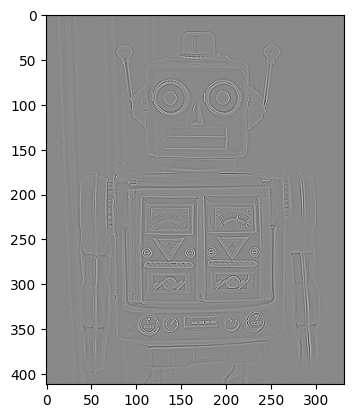

In [126]:
def grad(u):
    """Computes the discrete gradient of a (n x m) matrix."""
    
    (n, m) = u.shape
    grad = np.zeros((n,m,2))

    grad[:n-1,:,0] = u[1:n, :] - u[0:n-1, :]
    grad[:,:m-1,1] = u[:, 1:m] - u[:, 0:m-1]

    return grad

def div(v):
    """Computes the discrete divergence of a vector of size (n x m x 2)."""
    
    (n, m) = v.shape[:2]  # v is a vector of size n x m x 2
    v_x = v[:, :, 0]
    v_y = v[:, :, 1]
    div = np.zeros((n, m))
    
    div[0, :] += v_x[0, :]
    div[n-1, :] += -v_x[n-2, :]
    div[1:n-1, :] += (v_x[1:n-1, :] - v_x[0:n-2, :])
    
    div[:, 0] += v_y[:, 0]
    div[:, m-1] += -v_y[:, m-2]
    div[:, 1:m-1] += (v_y[:, 1:m-1] - v_y[:, 0:m-2])
    
    return div

def display(image):
    # Rescaling values from 0 to 1
    image = (image - np.min(image))/(np.max(image) - np.min(image))
    (n, m) = image.shape[:2]

    # Copying each value to a tuple
    gray_im = np.zeros((n,m,3))
    gray_im[:,:,0] = image
    gray_im[:,:,1] = image
    gray_im[:,:,2] = image

    plt.imshow(gray_im)


u = plt.imread("./robot_no_noise.jpg")
u = u[:,:,0]/255

laplacian = div(grad(u))  
display(laplacian)

On peut discerner les contours du robots ce qui est cohérent car c'est à ces endroits que les variations de couleurs sont élevées et donc que le laplacien le sera également. 

### Question 5 
_Algorithme de descente de gradient à pas fixe_

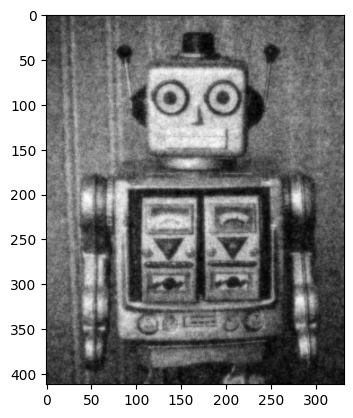

In [127]:
u_b = plt.imread("./robot_noise.jpg")[:,:,0]/255

def grad_f(u: np.ndarray) -> np.ndarray:
    """Returns the gradient of function f at matrix u."""
    return (u - u_b - 2*div(grad(u)))

def grad_descent(z0: np.ndarray, grad, step: float, eps: float=1e-8) -> np.ndarray:
    """Implements the gradient descent algorithm with a constant step."""
    z = z0
    n = 0
    
    while np.linalg.norm(grad(z), ord='fro') >= eps and n <= n_max:
        z = z - step * grad(z)
    
    return z

# Restoration
u_rest_1 = grad_descent(u_b, grad_f, step = 0.01, eps = 0.01)
display(u_rest_1)


### Question 6

_Quantification de l'écart_

In [128]:

def RMSE(z: np.ndarray) -> float:
    (n, m) = u.shape
    return (np.sqrt(np.linalg.norm(u - z)**2 / (n * m)))  # Frobenius norm

print(f"RMSE de l'image restaurée V1 : {RMSE(u_rest_1)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")
print(f"RMSE de l'image initiale : {RMSE(u)}")


RMSE de l'image restaurée V1 : 0.09646937713019083
RMSE de l'image bruitée : 0.1852844603784427
RMSE de l'image initiale : 0.0


On remarque que RMSE(signal dénoisé) < RMSE(signal bruité). C'est le résultat escompté ! 

On restaure donc légèrement l'image bruitée, mais c'est encore insatisfaisant.

### Question 7

_Comparaison à la bibliothèque Scipy_

  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: 2535.7832873341513
        x: [ 2.589e-01  2.474e-01 ...  9.021e-02  1.039e-01]
      nit: 22
      jac: [-2.449e-05 -1.132e-06 ...  3.049e-06 -1.064e-05]
     nfev: 27
     njev: 27
 hess_inv: <136784x136784 LbfgsInvHessProduct with dtype=float64>


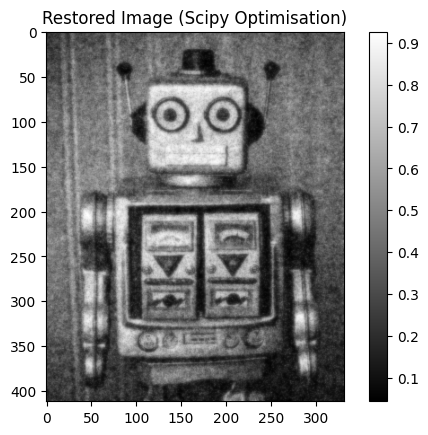

In [129]:
(n, m) = u.shape

# Flattening the arrays
u_b2 = u_b.flatten()  # Flattening to a 1D array
u2 = u.flatten()

# Defining the function f_2
def f_2(x):
  g = grad(x.reshape((n, m)))
  return 0.5 * np.sum((x - u_b2)**2) + np.linalg.norm(g)**2

# Defining the gradient of f_2
def grad_f_2(x):
  g = grad(x.reshape((n, m)))
  return (x - u_b2) - 2 * div(g).flatten()

# Using scipy.optimize.minimize with bounds and gradient
result = scipy.optimize.minimize(
  f_2,
  u_b2,
  method='L-BFGS-B',
  jac=grad_f_2,
)

print(result)
# Reshaping the result
u_rest_2 = result.x.reshape((n, m))

# Displaying the restored image
plt.imshow(u_rest_2, cmap='gray')
plt.title('Restored Image (Scipy Optimisation)')
plt.colorbar()
plt.show()


In [130]:
print(f"RMSE de l'image restaurée V2 : {RMSE(u_rest_2)}")

RMSE de l'image restaurée V2 : 0.0964768298595647


## Bilan 

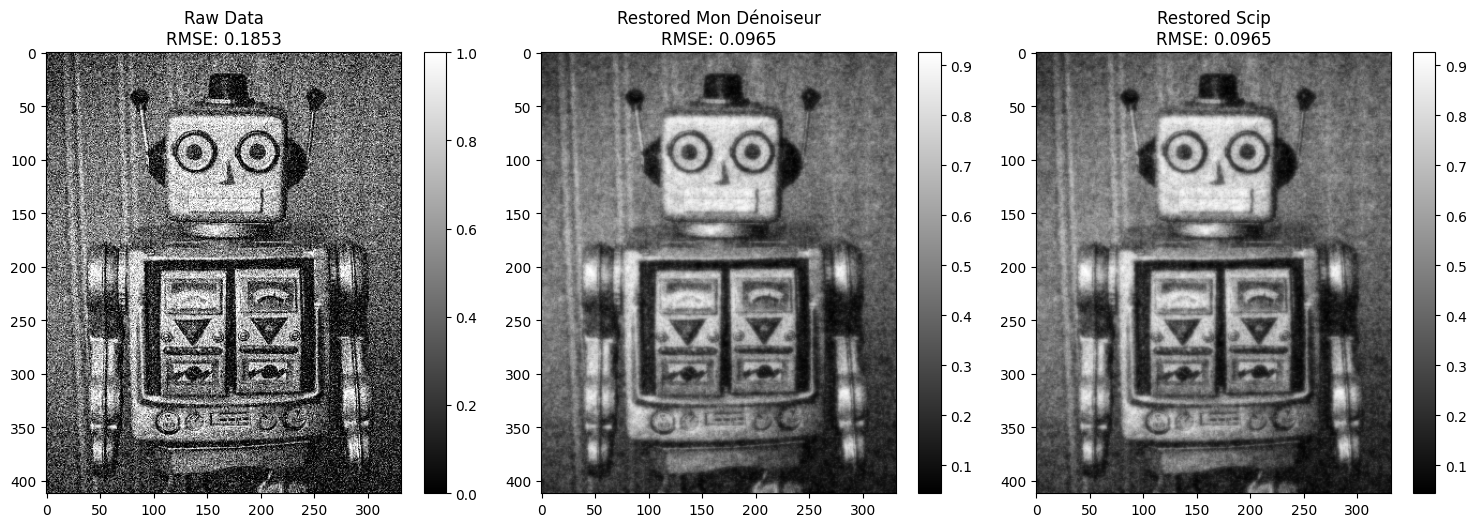

In [131]:
# Display the raw data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(u_b, cmap='gray')
plt.title(f'Raw Data\nRMSE: {RMSE(u_b):.4f}')
plt.colorbar()

# Display the first result
plt.subplot(1, 3, 2)
plt.imshow(u_rest_1, cmap='gray')
plt.title(f'Restored Mon Dénoiseur\nRMSE: {RMSE(u_rest_1):.4f}')
plt.colorbar()

# Display the second result
plt.subplot(1, 3, 3)
plt.imshow(u_rest_2, cmap='gray')
plt.title(f'Restored Scip\nRMSE: {RMSE(u_rest_2):.4f}')
plt.colorbar()

plt.tight_layout()
plt.show()

On a des résultats similaires avec les deux méthodes. La RMSE est également similaire. Dans les 2 cas, les détails sont assez bien conservés. 

# Partie 2 

## Question 8 - convexité et différentiabilité de TV-L2

- Le terme quadratique de la fonction $TV-L2$ est convexe et différentiable, comme nous l'avons vu à la partie précédente.

- Il reste à étudier le terme en $\| . \|_1$.

Soient $(u,v) \in \mathcal{M}_{n,m}(\mathbb{R})^2$ et $\lambda \in [0,1]$. On a :

\begin{equation*}
\begin{align*}
\sum_{(i,j)} \left\| \nabla \left(\lambda u + (1 - \lambda) v \right)(i,j) \right\|_1 &= \sum_{(i,j)} \left\| \lambda \nabla u(i,j) + (1 - \lambda) \nabla v(i,j)\right\|_1 \text{(linéarité du gradient discret)}\\
&= \sum_{(i,j)} \left( \lvert \lambda \nabla_x u(i,j) + (1 - \lambda) \nabla_x v(i,j) \rvert + \lvert \lambda \nabla_y u(i,j) + (1 - \lambda) \nabla_y v(i,j) \rvert \right) \\
&\leq \sum_{(i,j)} \left( \lambda \lvert \nabla_x u(i,j)\rvert + (1 - \lambda)\lvert \nabla_x v(i,j) \rvert + \lambda \lvert \nabla_y u(i,j)\rvert + (1 - \lambda)\lvert \nabla_y v(i,j) \rvert \right) \text{(inégalité triangulaire)}\\
&\leq \sum_{(i,j)} \left( \lambda \left\| \nabla u(i,j) \right\|_1 + (1 - \lambda) \left\| \nabla v(i,j) \right\|_1 \right) \\
&\leq \lambda \sum_{(i,j)} \left\| \nabla u(i,j) \right\|_1 + (1 - \lambda) \sum_{(i,j)} \left\| \nabla v(i,j) \right\|_1
\end{align*}
\end{equation*}

D'où la convexité du terme $\sum_{(i,j)} \left\| \nabla \cdot \right\|_1$.

- En raison de ce deuxième terme, $f$ n'est clairement pas différentiable aux points où $\nabla .$ s'annule en au moins un coefficient.

## Question 9 - Sous-gradient de f

- Remarquons tout d'abord que l'ensemble des points auxquels $f$ n'est pas différentiable est exactement: $\left\{u \in \mathcal{M}_{n,m}(\mathbb{R}) / \: \exists \: (i,j) \: : \nabla u(i,j) = 0 \right\}$. Sur cet ensemble, on montre, comme en (3), que le sous-différentiel de $f$ (réduit à un singleton) est donnée par la formule de l'énoncé.

- La principale difficulté concerne les points où $f$ n'est pas différentiable.

Soit $u \in \mathcal{M}_{n,m}(\mathbb{R})$ où $f$ n'est pas différentiable.

ie. Il existe $(i,j) \in \llbracket 1, n \rrbracket \times \llbracket 1, n \rrbracket$ tel que $\nabla u(i,j)$ est nulle.

On peut considérer des suites $(x_n^+)$ et $(x_n^-)$ tel que $x_n^+ \longrightarrow u$, $x_n^- \longrightarrow u$ et $f$ est différentiable en chacun des $x_n^+$, $x_n^-$.

On peut également imposer (quitte à prendre des suites extraites) que

\begin{equation*}
\nabla x_n^+(i,j) =
\begin{cases}
\nabla u(i,j) \text{ si } \nabla u(i,j) \neq 0 \\
\nabla x_n^+(i,j) > 0 \text{ si } \nabla u(i,j) = 0
\end{cases}
\end{equation*}

\begin{equation*}
\nabla x_n^-(i,j) =
\begin{cases}
\nabla u(i,j) \text{ si } \nabla u(i,j) \neq 0 \\
\nabla x_n^-(i,j) < 0 \text{ si } \nabla u(i,j) = 0
\end{cases}
\end{equation*}

On construit facilement de telles suites en considérant que l'ensemble des points de non différentiabilité est de mesure nulle pour une fonction convexe. 
  
Soit $n \in \mathbb{N}$. On applique la formule du gradient - cas différentiable :

\begin{equation*}
\begin{align*}
\frac{1}{2} \left( \nabla f(x_n^+) + \nabla f(x_n^-) \right) &= \frac{1}{2} \left[ x_n^+ + x_n^- - 2u_b - 2 \text{div}(\text{sign}(x_n^+)) - 2 \text{div}(\text{sign}(x_n^-)) \right]\\
&= \frac{1}{2} \left[ x_n^+ + x_n^- - 2u_b - 2 \text{div}(\text{sign}(\nabla x_n^+) + \text{sign}(\nabla x_n^-)) \right]
\end{align*}
\end{equation*}
par linéarité de l'application div.

Or :

\begin{equation*}
\begin{align*}
\text{sign}(\nabla x_n^+)(i,j) + \text{sign}(\nabla x_n^-)(i,j) &= \text{sign}(\nabla x_n^+(i,j)) + \text{sign}(\nabla x_n^-(i,j)) \\
&=
\begin{cases}
2 \text{ sign}(\nabla u(i,j)) \text{ si } \nabla u(i,j) \neq 0 \\
1 - 1 = 0 = 2 \text{ sign}(\nabla u(i,j)) \text{ si } \nabla u(i,j) = 0 
\end{cases} \\
&= 2 \text{ sign}(\nabla u)(i,j).
\end{align*}
\end{equation*}

Donc $\text{sign}(\nabla x_n^+) + \text{sign}(\nabla x_n^-) = 2 \text{ sign}(\nabla u)$ puis

\begin{equation*}
\frac{1}{2} \left( \nabla f(x_n^+) + \nabla f(x_n^-) \right) = \frac{1}{2} \left( x_n^+ + x_n^- \right) - u_b - 2 \text{div}(\text{sign}(\nabla u))
\end{equation*}.

On en déduit donc que

\begin{equation*}
\frac{1}{2} \left( \nabla f(x_n^+) + \nabla f(x_n^-) \right) \longrightarrow \quad u - u_b - 2 \text{div}(\text{sign}(\nabla u))
\end{equation*}.

Or $\lim_{n \to +\infty} \nabla f(x_n^+)$ et $\lim_{n \to +\infty} \nabla f(x_n^-)$ sont dans $\left\{ \lim_{n \to +\infty} \nabla f(x_n) / x_n \to u \right\}$ donc

\begin{equation*}
\frac{1}{2} \lim_{n \to +\infty} \nabla f(x_n^+) + \left( 1 - \frac{1}{2} \right) \lim_{n \to +\infty} \nabla f(x_n^-) \in \text{Conv} \left( \left\{ \lim_{n \to +\infty} \nabla f(x_n) / x_n \to u \right\} \right)
\end{equation*}

ie.

\begin{equation*}
\boxed{u - u_b - 2 \: \text{div}(\text{sign}(\nabla u)) \in \partial f(u)}
\end{equation*}.


## Question 10


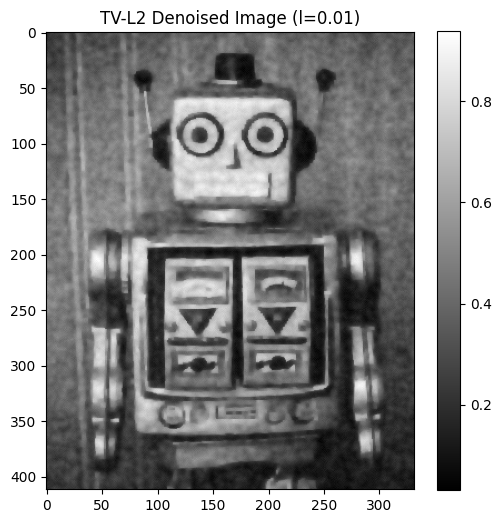

RMSE de l'image restaurée V3 : 0.09042020436676729
RMSE de l'image bruitée : 0.1852844603784427


In [132]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_2(grad_fun, x0, l, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0 
    for k in range(max_iter):
        counter += 1 
        x_k = x_k - (l/(k+1)) * grad_fun(x_k,x0)
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)/(k+1)) < epsilon_grad_fun: 
            break
    return x_k, L_x, counter

u_rest_3 = optim_gradient_fixed_step_2(subgradient_tv_l2,u_b, 0.076, n_max, 100)[0]
# Display the first restored image
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(u_rest_3, cmap='gray')
plt.title('TV-L2 Denoised Image (l=0.01)')
plt.colorbar()

plt.tight_layout()
plt.show()

print(f"RMSE de l'image restaurée V3 : {RMSE(u_rest_3)}")
print(f"RMSE de l'image bruitée : {RMSE(u_b)}")


La RMSE obtenue avec cette méthode est plus élevée que la précédente ce qui indique une meilleure restauration. En revanche, l'image devient floue et la RMSE dépasse la précédente. Visuellement, il semblerait que l'homogénéité des couleurs prime sur les détails. 

## Question 11

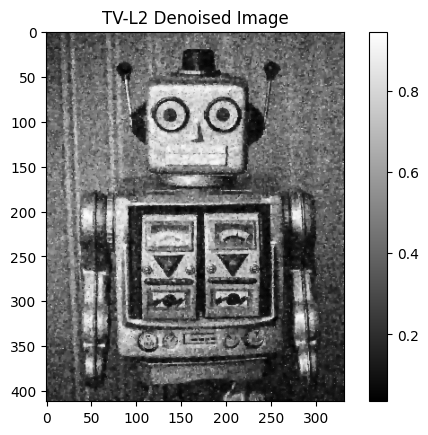

RMSE de l'image restaurée V4 : 0.08601153379784938


In [133]:
def subgradient_tv_l2(u, u_b):
    sig_grad = np.sign(grad(u))
    div_sig_grad = div(sig_grad) 
    return u - u_b - div_sig_grad

def optim_gradient_fixed_step_3(grad_fun, x0, l, beta = 0, max_iter = 100, epsilon_grad_fun = 1e-8):
    L_x = [x0]
    x_k = x0
    counter = 0
    p_k = 0 
    for k in range(max_iter):
        counter += 1 
        p_k = (beta * p_k + (1-beta) * (-grad_fun(x_k,x0)))/(k+1)
        x_k = x_k + l * p_k
        L_x.append(x_k)
        if np.linalg.norm(grad_fun(x_k,x0)/(k+1)) < epsilon_grad_fun: 
            break
        
    return x_k, L_x, counter

u_rest_4 = optim_gradient_fixed_step_3(subgradient_tv_l2,u_b, l, 0.76, n_max, 100)[0]

plt.imshow(u_rest_4, cmap='gray')
plt.title('TV-L2 Denoised Image')
plt.colorbar()
plt.show()

print(f"RMSE de l'image restaurée V4 : {RMSE(u_rest_4)}")


Cette méthode mène à une meilleure RMSE. On s'est approché du résultat plus rapidement. 

## Bilan 

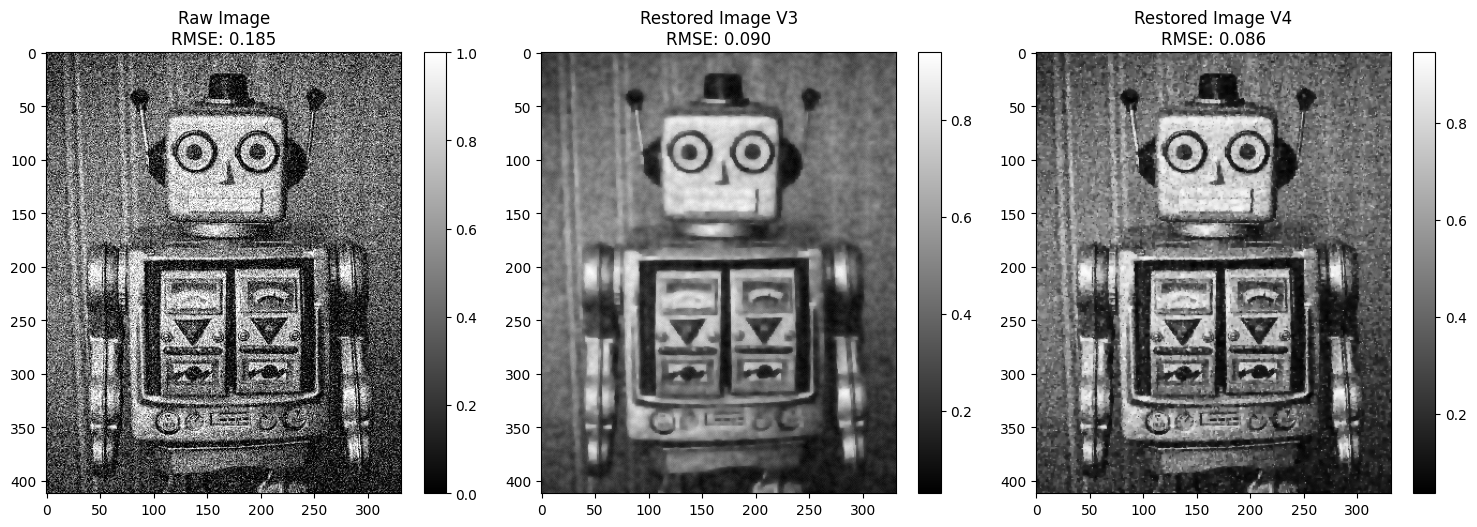

In [134]:
# Display the raw image and RMSE values for comparison
plt.figure(figsize=(15, 5))

# Display the raw noisy image
plt.subplot(1, 3, 1)
plt.imshow(u_b, cmap='gray')
plt.title(f'Raw Image\nRMSE: {RMSE(u_b):.3f}')
plt.colorbar()

# Display the first restored image
plt.subplot(1, 3, 2)
plt.imshow(u_rest_3, cmap='gray')
plt.title(f'Restored Image V3\nRMSE: {RMSE(u_rest_3):.3f}')
plt.colorbar()

# Display the second restored image
plt.subplot(1, 3, 3)
plt.imshow(u_rest_4, cmap='gray')
plt.title(f'Restored Image V4\nRMSE: {RMSE(u_rest_4):.3f}')
plt.colorbar()

plt.tight_layout()
plt.show()

Pour trouver un équilibre entre régularité et fidélité à l'image initiale, on pourrait ajouter un poids devant les termes de TVL2 et les adapter pour obtenir le résultat souhaité. 

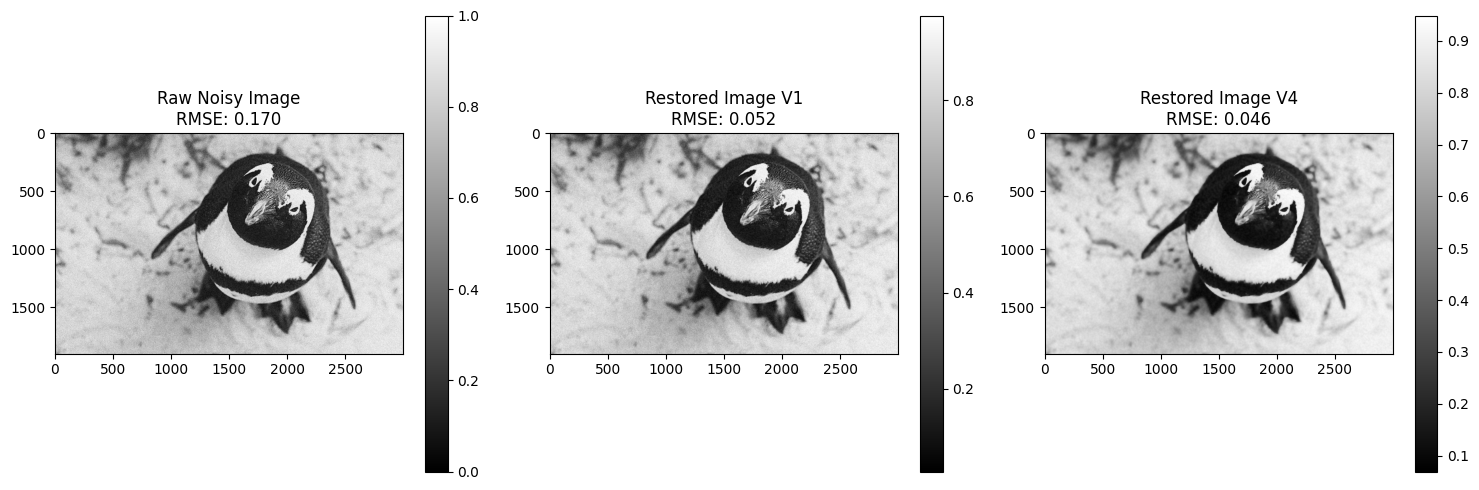

In [137]:
v = plt.imread("./penguin.jpg")[:,:,0]/255

v_b = v + np.random.normal(0, 0.2, v.shape)
v_b = np.clip(v_b, 0, 1)

def grad_v(v: np.ndarray) -> np.ndarray:
    """Returns the gradient of function f at matrix u."""
    return (v - v_b - 2*div(grad(v)))

v_rest_1 = grad_descent(v_b, grad_v, step = 0.1, eps = 10)
v_rest_4 = optim_gradient_fixed_step_3(subgradient_tv_l2,v_b, l, 0.01, n_max, 100)[0]

def RMSE_v(z: np.ndarray) -> float:
    (n, m) = v.shape
    return (np.sqrt(np.linalg.norm(v - z)**2 / (n * m)))  # Frobenius norm

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(v_b, cmap='gray')
plt.title(f'Raw Noisy Image\nRMSE: {RMSE_v(v_b):.3f}')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(v_rest_1, cmap='gray')
plt.title(f'Restored Image V1\nRMSE: {RMSE_v(v_rest_1):.3f}')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(v_rest_4, cmap='gray')
plt.title(f'Restored Image V4\nRMSE: {RMSE_v(v_rest_4):.3f}')
plt.colorbar()

plt.tight_layout()
plt.show()
